In [1]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'../..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import numpy as np
import torch
import config

/home/abian/Workspace/Anaconda/envs/CLHU/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dataset import Apex
dataset = Apex(config.Apex_PATH)

result_path = os.path.join(config.RESULTS_PATH, 'apex')

In [3]:
dataset.wv

array([ 413,  420,  427,  434,  441,  448,  455,  462,  469,  476,  483,
        490,  497,  504,  511,  519,  526,  533,  540,  547,  554,  561,
        568,  575,  582,  589,  596,  603,  610,  617,  625,  632,  639,
        646,  653,  660,  667,  674,  681,  688,  695,  702,  709,  716,
        723,  731,  738,  745,  752,  759,  766,  773,  780,  787,  794,
        801,  808,  815,  822,  829,  837,  844,  851,  858,  865,  872,
        879,  886,  893,  900,  907,  914,  921,  928,  935,  943,  950,
        957,  964,  971,  978,  985,  992,  999, 1006, 1013, 1020, 1027,
       1034, 1041, 1049, 1056, 1063, 1070, 1077, 1084, 1091, 1098, 1105,
       1112, 1119, 1126, 1133, 1140, 1147, 1155, 1162, 1169, 1176, 1183,
       1190, 1197, 1204, 1211, 1218, 1225, 1232, 1239, 1246, 1253, 1261,
       1268, 1275, 1282, 1289, 1296, 1303, 1310, 1317, 1324, 1331, 1338,
       1345, 1352, 1359, 1367, 1374, 1381, 1388, 1395, 1402, 1409, 1416,
       1423, 1430, 1437, 1444, 1451, 1458, 1465, 14

# Ground Truth

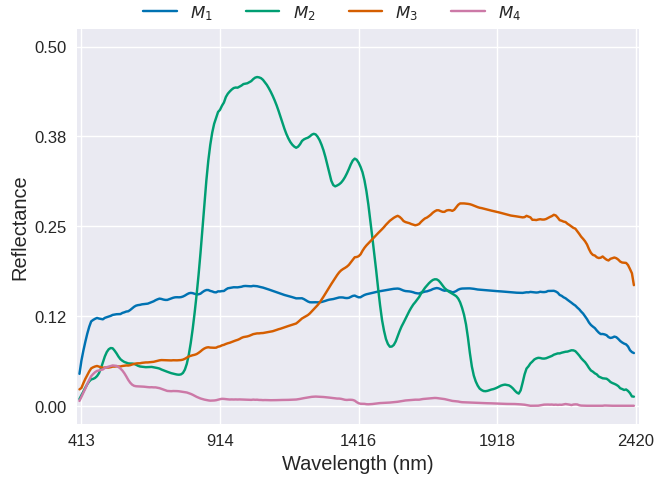

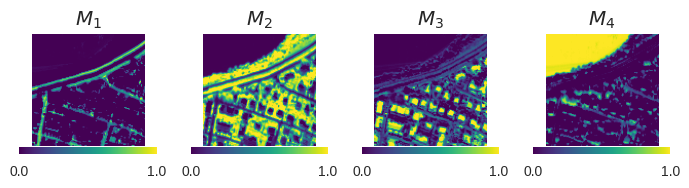

In [4]:
from utils import plot_endmembers, show_abundance
fig = plot_endmembers(dataset.endmembers(), np.array(dataset.wv), ticks_range=(0, .5), n_ticks=5)
plt.show(fig)
fig.savefig(os.path.join(result_path, 'imgs/M_ref.pdf'), bbox_inches='tight')

fig = show_abundance(dataset.abundance())
plt.show(fig)
fig.savefig(os.path.join(result_path, 'imgs/A_ref.png'), dpi=300, bbox_inches='tight')

In [5]:
dataset.endmembers().shape, dataset.wv.shape

(torch.Size([4, 285]), (285,))

In [6]:
from HySpecLab.metrics import sad

def sort_endmember(endmembers, gt):
    sad_result = sad(endmembers, gt)
    e_idx = torch.argmin(sad_result, dim=0) # Index for reordering the ground truth
    return e_idx, sad_result

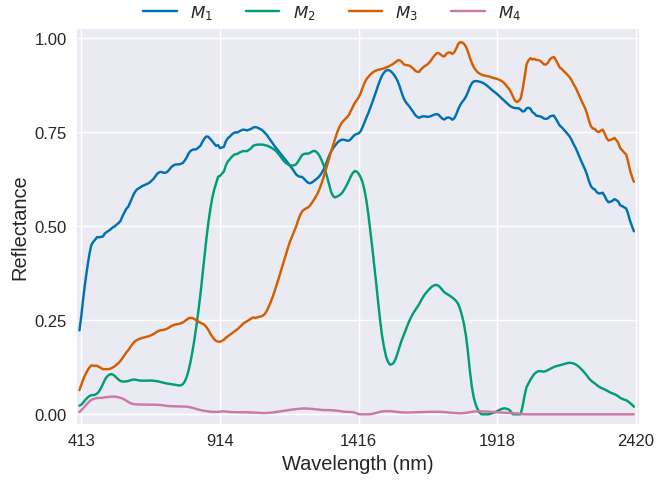

In [7]:
from HySpecLab.eea import VCA

n_endmembers = dataset.n_endmembers
   
vca = VCA(n_endmembers, snr_input=20, random_state=42)
vca.fit(dataset.X.numpy())
endmembers = torch.from_numpy(vca.endmembers()).float()
e_idx, sad_result = sort_endmember(endmembers, dataset.endmembers())

vca_endmember_init = endmembers[e_idx]
vca_logit_endmember_init = torch.log((vca_endmember_init + 1e-12) / ((1-vca_endmember_init) + 1e-12))

fig = plot_endmembers(vca_endmember_init, dataset.wv, ticks_range=(0, 1))
plt.show(fig)

fig.savefig(os.path.join(result_path, 'imgs/M_vca.pdf'), bbox_inches='tight')

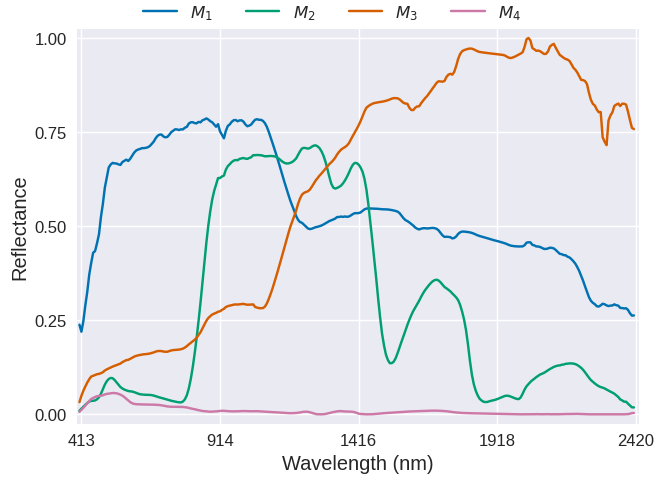

In [8]:
from utils import plot_endmembers
from pysptools import eea
n_endmembers = dataset.n_endmembers

ee = eea.NFINDR()
endmember = torch.from_numpy(ee.extract(dataset.image(), n_endmembers)).float()

e_idx, _ = sort_endmember(endmember, dataset.endmembers())
nfindr_endmember_init = endmember[e_idx]
nfindr_logit_endmember_init = torch.log((nfindr_endmember_init + 1e-12) / ((1-nfindr_endmember_init) + 1e-12))

fig = plot_endmembers(nfindr_endmember_init, dataset.wv, ticks_range=(0, 1))
plt.show(fig)
fig.savefig(os.path.join(result_path, 'imgs/M_nfindr.pdf'), bbox_inches='tight')

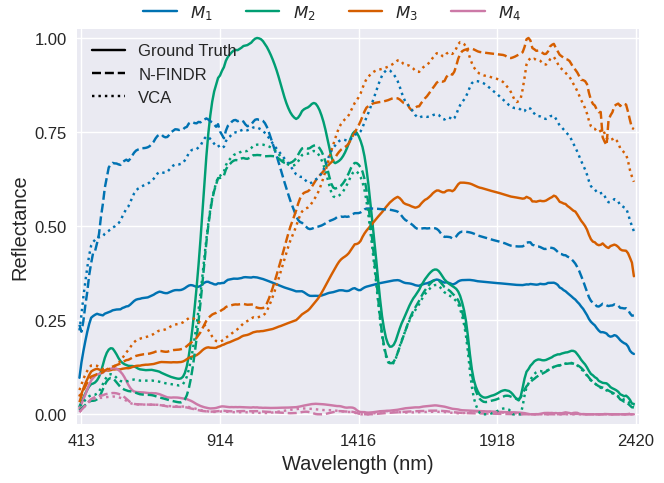

In [9]:
fig = plot_endmembers(dataset.endmembers() / dataset.endmembers().max(), dataset.wv, ticks_range=(0, 1), endmember_estimation=[nfindr_endmember_init, vca_endmember_init], ee_labels=['Ground Truth', 'N-FINDR', 'VCA'])
plt.show(fig)
fig.savefig(os.path.join(result_path, 'imgs/M_estimation.pdf'), bbox_inches='tight')

In [10]:
# endmember_init_method = 'nfindr'
# endmember_init = nfindr_endmember_init
# logit_endmember_init = nfindr_logit_endmember_init

endmember_init_method = 'vca'
endmember_init = vca_endmember_init
logit_endmember_init = vca_logit_endmember_init

# Training

In [11]:
from utils import train 
from HySpecLab.unmixing import ContrastiveUnmixing

n_bands = dataset.n_bands
model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init)
train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3, simplex_weight=5e-5)

285


100%|██████████| 50/50 [00:22<00:00,  2.22epoch/s, tls=0.1488]


# Save Model

In [13]:
torch.save(model.state_dict(), os.path.join(result_path, 'clhu/weights/clhu.pth'))

# Testing model

In [15]:
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss
from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy

model.eval()
criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers)
similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')

In [16]:
from torch import sigmoid 
_X = dataset.X

model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), volume_reg(sigmoid(model.ebk)).cpu(),
         similarity_reg(sigmoid(model.ebk)).cpu())
    

tensor(0.0905) tensor(0.5598) tensor(7915.9038) tensor(0.1377)


In [18]:
volume_reg(endmember_init), similarity_reg(endmember_init)

(tensor(3970.2607), tensor(0.2355))

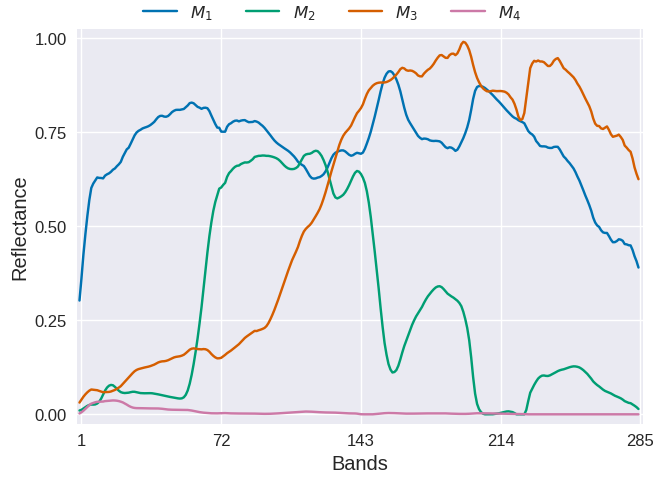

In [19]:
ebk = torch.sigmoid(model.ebk).detach().cpu()
if endmember_init_method == 'vca':
    label = 'VCA'
else:
    label = 'N-FINDR'
# fig = plot_endmembers(ebk, ticks_range=(0, 1), endmember_estimation=[endmember_init], ee_labels=['CLHU',label])
fig = plot_endmembers(ebk, ticks_range=(0, 1))

plt.show(fig)
# fig.savefig(os.path.join(result_path, 'clhu/imgs/M_clhu.pdf'), bbox_inches='tight')

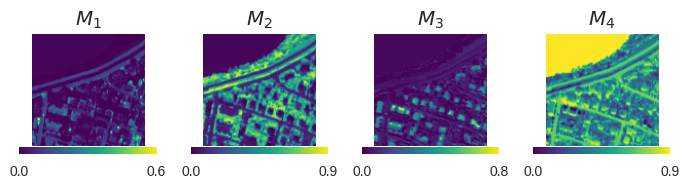

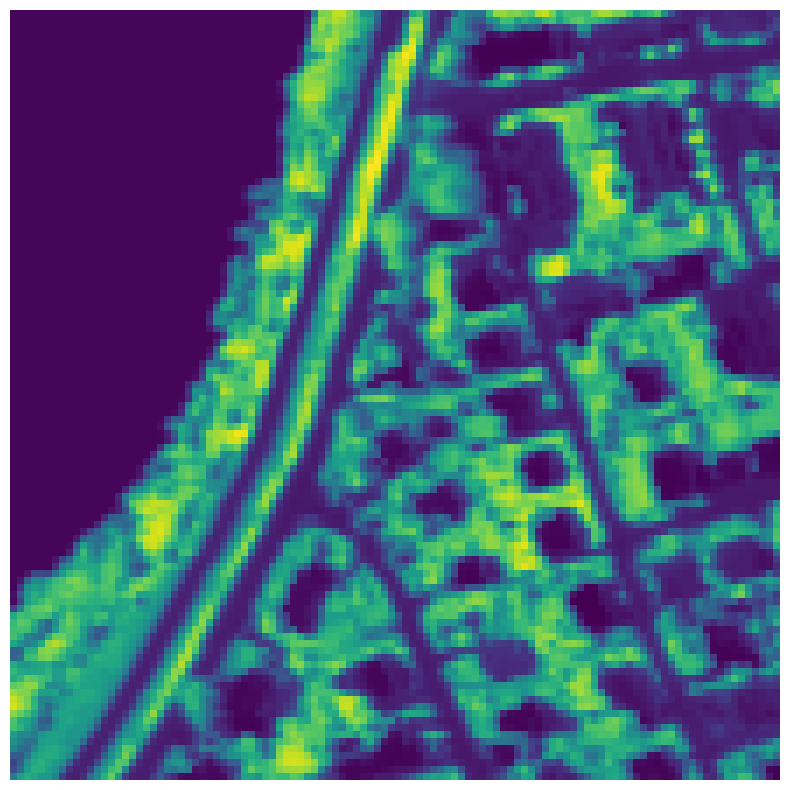

In [20]:
from torch.nn.functional import softmax
 
test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(dataset.n_row, dataset.n_col, -1)

fig = show_abundance(test)
plt.show(fig)

# imshow bigger test[:,:,0]
test1 = test[:,:,1]
# test1[test1>.3] = 1
fig = plt.figure(figsize=(10,10))
plt.imshow(test1, cmap='viridis')
plt.axis('off')
plt.show(fig)

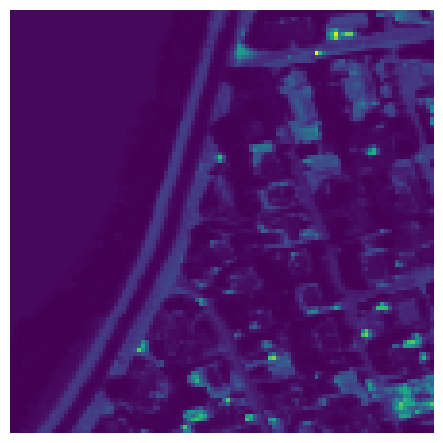

In [88]:
test2 = test[:, :, 0]

# test2[test2 > .5] = 1
plt.imshow( test2, cmap='viridis')
plt.axis('off')
plt.show()



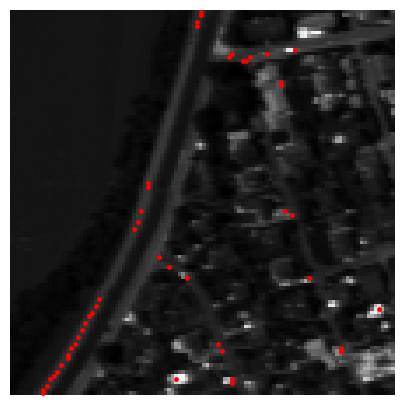

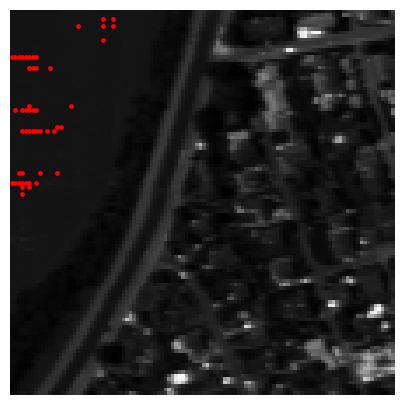

(50, 285) (50, 285)


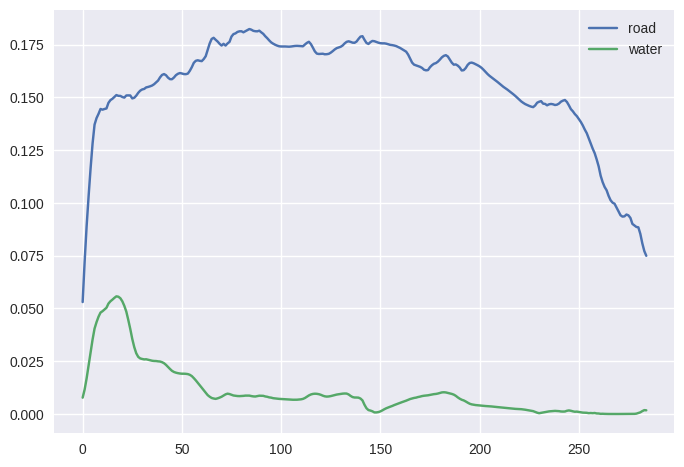

tensor(0.8785)

In [68]:
A_road = dataset.abundance()[:,:,0]
# find the coordinates of the 10 pixels with highest values
idx = np.unravel_index(np.argsort(A_road.ravel())[-50:], A_road.shape)
# plot the 10 pixels
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(dataset.image()[:,:, 10], cmap='gray')
ax.scatter(idx[1], idx[0], s=10, c='r')
ax.axis('off')  
plt.show()

A_water = dataset.abundance()[:,:,-1]
idx_water = np.unravel_index(np.argsort(A_water.ravel())[-50:], A_water.shape)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(dataset.image()[:,:, 10], cmap='gray')
ax.scatter(idx_water[1], idx_water[0], s=10, c='r')
ax.axis('off')
plt.show()


signal_road = dataset.image()[idx[0], idx[1], :]
signal_water = dataset.image()[idx_water[0], idx_water[1], :]

print(signal_road.shape, signal_water.shape)
plt.plot(signal_road.mean(axis=0), label='road')
plt.plot(signal_water.mean(axis=0), label='water')
plt.legend()
plt.show()

# compute sad between signal_road mean and signal_water mean
from HySpecLab.metrics import sad
sad(torch.tensor(signal_road.mean(axis=0)).reshape(1,-1), torch.tensor(signal_water.mean(axis=0)).reshape(1,-1))


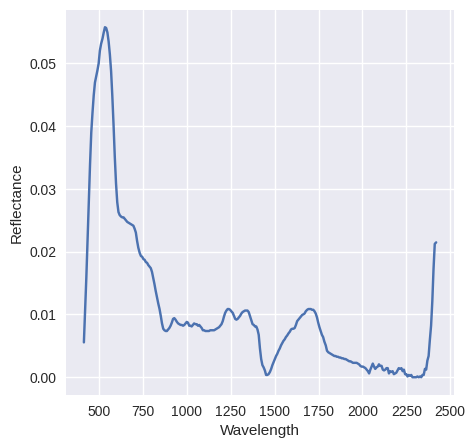

In [36]:
#plot the signal of the water
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(dataset.wv, dataset.image()[0, 0, :].T)
ax.set_xlabel('Wavelength')
ax.set_ylabel('Reflectance')
plt.show()



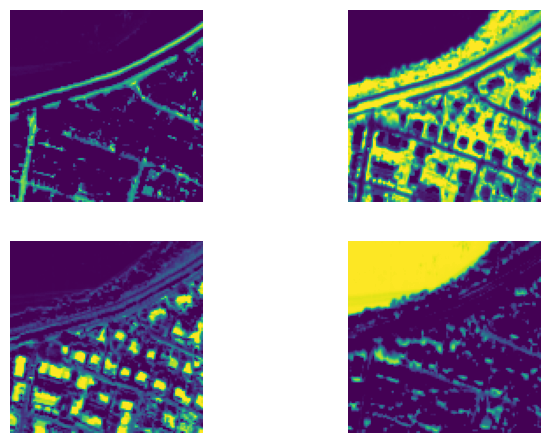

In [66]:
dataset = Apex('/home/abian/Data/Dataset/HSI/Apex/')
A = dataset.abundance()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(A[:,:,i], cmap='viridis')
    plt.axis('off')
plt.show()



# ...

In [104]:
from HySpecLab.metrics import rmse
from torch import sigmoid
def test(model, dataset):
    X = dataset.X
    model.eval()
    model = model.cpu()
    
    X_true = dataset.A @ dataset.endmembers()
    with torch.no_grad():
        X_hat = model(dataset.X)
        A_hat = torch.softmax(model.A, dim=1)
        M_hat = sigmoid(model.ebk) 
    
    rmse_x = rmse(X_true, X_hat, dim=None).numpy()      
    rmse_a = rmse(dataset.A, A_hat, dim=None).numpy()
    sad_m = np.diagonal(sad(M_hat, dataset.endmembers()).numpy()).mean()
    return rmse_x.item(), rmse_a.item(), sad_m

In [105]:
from HySpecLab.unmixing import ContrastiveUnmixing

n_bands = dataset.n_bands

batch_rmse_x = []
batch_rmse_a = []
batch_sad_m = []
for i in range(10):
    model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init)
    train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3, simplex_weight=5e-3)

    rmse_x, rmse_a, sad_m = test(model, dataset)
    batch_rmse_x.append(rmse_x)
    batch_rmse_a.append(rmse_a)
    batch_sad_m.append(sad_m)

    print(rmse_x, rmse_a, sad_m)

100%|██████████| 50/50 [00:23<00:00,  2.14epoch/s, tls=0.1412]


0.06615788489580154 0.27335160970687866 0.11546324


100%|██████████| 50/50 [00:23<00:00,  2.17epoch/s, tls=0.1366]


0.06860088557004929 0.26997512578964233 0.11275859


100%|██████████| 50/50 [00:22<00:00,  2.19epoch/s, tls=0.1406]


0.06440061330795288 0.2784478962421417 0.11637767


100%|██████████| 50/50 [00:22<00:00,  2.20epoch/s, tls=0.1382]


0.05983661860227585 0.2744463086128235 0.1172193


100%|██████████| 50/50 [00:22<00:00,  2.22epoch/s, tls=0.1654]


0.06291547417640686 0.2989402711391449 0.11625917


100%|██████████| 50/50 [00:22<00:00,  2.23epoch/s, tls=0.1422]


0.06627543270587921 0.27675870060920715 0.1119781


100%|██████████| 50/50 [00:22<00:00,  2.18epoch/s, tls=0.1469]


0.06568355858325958 0.2787870168685913 0.11361851


100%|██████████| 50/50 [00:23<00:00,  2.09epoch/s, tls=0.1431]


0.06284668296575546 0.27432361245155334 0.11389528


100%|██████████| 50/50 [00:21<00:00,  2.27epoch/s, tls=0.1439]


0.06643829494714737 0.26741674542427063 0.114988096


100%|██████████| 50/50 [00:27<00:00,  1.82epoch/s, tls=0.1346]

0.06814409047365189 0.2726009488105774 0.113452315


In [106]:
# generate dataframe
import pandas as pd
df = pd.DataFrame(columns=['RMSE_X', 'RMSE_A', 'SAD_M'])
df['RMSE_X'] = batch_rmse_x
df['RMSE_A'] = batch_rmse_a
df['SAD_M'] = batch_sad_m

# extract mean and std
df['RMSE_X'].mean(), df['RMSE_X'].std(), df['RMSE_A'].mean(), df['RMSE_A'].std(), df['SAD_M'].mean(), df['SAD_M'].std()

(0.065129953622818,
 0.0026705797766134994,
 0.2765048235654831,
 0.008639740080336324,
 0.11460103,
 0.0017227806383743882)

In [107]:
df.to_csv(os.path.join(result_path, 'clhu/metrics_{}_batch.csv'.format(endmember_init_method)), index=False)

In [109]:
print(np.diagonal(sad(endmember_init, dataset.endmembers()).numpy()).mean())
print(np.diagonal(sad(sigmoid(model.ebk.detach()).cpu(), dataset.endmembers()).numpy()).mean())

0.108870044
0.113452315


In [110]:
sad(sigmoid(model.ebk.detach()).cpu(), dataset.endmembers())

tensor([[0.0548, 0.7028, 0.4438, 0.9043],
        [0.7100, 0.1238, 0.9404, 1.1771],
        [0.5143, 0.9704, 0.0998, 1.2637],
        [1.0227, 1.2733, 1.3056, 0.1754]])

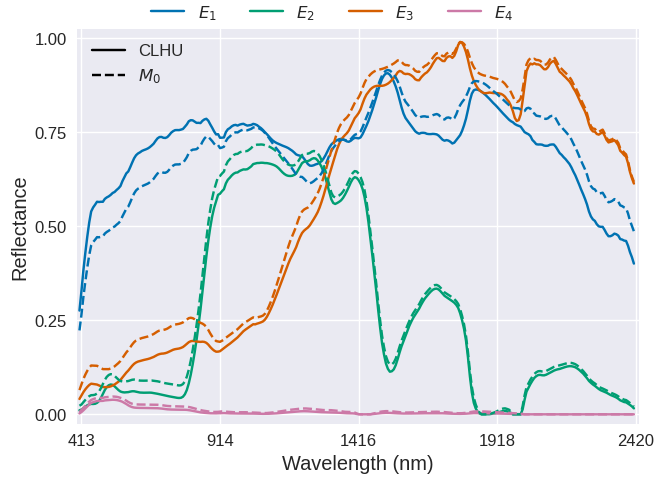

In [112]:
fig = plot_endmembers(sigmoid(model.ebk.detach()).cpu(), dataset.wv, ticks_range=(0, 1), endmember_estimation=[endmember_init], ee_labels=['CLHU', '$M_0$'])
plt.show(fig)

In [113]:
sad(endmember_init, endmember_init)

tensor([[5.9802e-04, 7.2831e-01, 3.9741e-01, 9.6309e-01],
        [7.2831e-01, 3.4527e-04, 9.2891e-01, 1.1667e+00],
        [3.9741e-01, 9.2891e-01, 0.0000e+00, 1.2278e+00],
        [9.6309e-01, 1.1667e+00, 1.2278e+00, 0.0000e+00]])

In [114]:
sad(sigmoid(model.ebk.detach()).cpu(), sigmoid(model.ebk.detach()).cpu())

tensor([[       nan, 7.3462e-01, 5.0926e-01, 1.0239e+00],
        [7.3462e-01, 4.8828e-04, 9.4960e-01, 1.3107e+00],
        [5.0926e-01, 9.4960e-01, 0.0000e+00, 1.3576e+00],
        [1.0239e+00, 1.3107e+00, 1.3576e+00, 4.8828e-04]])